In [1]:
import numpy as np
import pandas as pd
from qiskit.circuit import QuantumCircuit
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit import IBMQ, Aer #necesaria para llamar a la plataforma IBM Quantum
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit #necesaria para crear bits, qubits y circuitos
from qiskit import execute #necesaria para dar la orden de ejecución
from scipy.stats import beta
from qiskit.providers.fake_provider import FakeManila
from qiskit_ibm_runtime import Options

n_bits = 2
b_max = np.pi/4
backend_list = []



IBMProvider.save_account(token="d83e53dfa62683e4eb3ed49770c00c03322d6c921625a94e55cb84c76414b00d915b95732b9e00f1f7502809a7575326ab91316d0eac89acebfd88cc52e483aa", overwrite=True)

print("Realizar simulación en ordenador real o en simulador?")
#job_type = str(input())
job_type = "SIMULADOR"


while job_type.upper() not in {"REAL", "SIMULADOR"}:
    print("Por favor, introduce un parámetro válido -> real / simulador")
    job_type = str(input())


if job_type.upper() == "REAL":
    #en caso de querer realizar una ejecución en un ordenador cuántico tenemos dos posibilidades, EXTERNO o CSIC (cátedra UAM / IBM)
    acceso = "EXTERNO"
    Backend_qubits = 20
    print("Acceso seleccionado: "+acceso)
else:
    None


if job_type.upper() == "SIMULADOR":
    provider = IBMProvider()
    #backend = provider.get_backend("ibmq_qasm_simulator")
    backend = Aer.get_backend('qasm_simulator')
    #fake_backend = FakeManila()

    ## Set options to include the noise model
    #options = Options()
    #options.simulator.set_backend(fake_backend)
    #options.simulator.seed_simulator = 42
#
    ## Set number of shots, optimization_level and resilience_level
    #options.optimization_level = 0
    #options.resilience_level = 0
    print("Simulador configurado correctamente: "+str(backend))
else:
    if acceso == 'CSIC' :
        # number of qubits to represent the uncertainty ***********************************************************************************************************
        numero_de_qbits_de_incertidumbre = 3
        #**********************************************************************************************************************************************************
        provider = IBMProvider(hub='ibm-q-csic')
        provider.backends()
        backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= Backend_qubits and
        not b.configuration().simulator and b.status().operational==True))
        print(backend)
        sistema_cuantico = str(backend)
        print("El programa se ejecutará en: "+str(sistema_cuantico))
        print (sistema_cuantico)
    
    else :
        # number of qubits to represent the uncertainty ***********************************************************************************************************
        numero_de_qbits_de_incertidumbre = 3
        #**********************************************************************************************************************************************************
        # Loading your IBM Quantum account(s)
        provider = IBMProvider()
        provider.backends()
        print("The available backends are: "+str(provider.backends()))
        backend = least_busy(provider.backends(filters=lambda x: x.configuration().simulator == False and x.status().operational == True))
        print("Por como están de ocupados los ordenadores cuánticos, el programa se ejecutará en: "+str(backend))


#quantum_instance = QuantumInstance(backend)

Realizar simulación en ordenador real o en simulador?
Simulador configurado correctamente: qasm_simulator


In [2]:
def P(qc, qx):
    """
        Generación de ua distribución de probablidad uniforme
            qc: quantum circuit
            qx: quantum register
            nbit: number of qubits
        The inverse of P = P
    """
    qc.h(qx[:-1])

def A(qc, qx, qx_measure, nbit, b_max):
    """
        Preparación del estado, integral de f()
            qc: quantum circuit
            qx: quantum register
            qx:measure: quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral            
    """
    qc.ry(b_max / 2**nbit * 2 * 0.5, qx_measure[-1])
    
    for i in range(nbit):
        qc.cry(2**i * b_max / 2**nbit * 2, qx[nbit-1-i], qx_measure[-1])
               
        
def Ainv(qc, qx, qx_measure, nbit, b_max):
    """
        Puerta inversa de A
            qc: quantum circuit
            qx: quantum register
            qx_measure : quantum register for measurement
            nbit: number of qubits
            b_max: upper limit of integral
    """
    for i in range(nbit)[::-1]:
        qc.cry(-2**i * b_max / 2**nbit * 2, qx[nbit-1-i], qx_measure[-1])
     
    qc.ry(-b_max / 2**nbit * 2 * 0.5, qx_measure[-1])

def multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit):    
    """
        Creación de la puerta cuántica multi control NOT. 
            qc: circuito cuántico
            qx: registro
            qx_measure: registro sobre el que realizaremos la medida
            qx_ancilla: bit ancilla de control. 
            nbit: number of qubits
    """

    if nbit == 1:
        qc.cz(qx[0], qx_measure[-1])
        
    elif nbit == 2:
        qc.h(qx_measure[-1])
        qc.ccx(qx[0], qx[1], qx_measure[-1])
        qc.h(qx_measure[-1])
        
    elif nbit > 2.0:
        qc.ccx(qx[0], qx[1], qx_ancilla[0])
        
        for i in range(nbit - 3):
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
            
        qc.h(qx_measure[-1])
        qc.ccx(qx[nbit - 1], qx_ancilla[nbit - 3], qx_measure[-1])
        qc.h(qx_measure[-1])
        
        for i in range(nbit - 3)[::-1]:
            qc.ccx(qx[i + 2], qx_ancilla[i], qx_ancilla[i + 1])
            
        qc.ccx(qx[0], qx[1], qx_ancilla[0])


#def reflect(qc, qx, qx_measure, qx_ancilla, nbit, b_max):        
def S_0(qc, qx, qx_measure, qx_ancilla, nbit):
    """
        Operador de reflexion (I - 2|0><0|). Hacemos la reflexión sobre el eje del vector complejo
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.barrier()
    for i in range(nbit):
        qc.x(qx[i])
    
    qc.x(qx_measure[-1])
    #multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit, b_max)
    multi_control_NOT(qc, qx, qx_measure, qx_ancilla, nbit)
    qc.x(qx_measure[-1])
    
    for i in range(nbit):
        qc.x(qx[i])
    
    qc.barrier()

# This is to implement Grover Operator Q
def Q(qc, qx, qx_measure, qx_ancilla, nbit, b_max):
    """
        El operador de Grover
            qc: quantum circuit
            qx: quantum register
            qx_measure: quantum register for measurement
            qx_ancilla: temporal quantum register for decomposing multi controlled NOT gate
            nbit: number of qubits
            b_max: upper limit of integral
    """
    qc.z(qx_measure[-1])
    qc.barrier()
    
    Ainv(qc, qx, qx_measure, nbit, b_max)
    qc.barrier()
    P(qc, qx)

    S_0(qc, qx, qx_measure, qx_ancilla, nbit)
    P(qc, qx)
    qc.barrier()
    A(qc, qx, qx_measure, nbit, b_max)

def create_grover_circuit(number_grover, nbit, b_max):
    """
        To generate quantum circuits running Grover operators with number of iterations in number_grover
            numebr_grover: number of Grover operators
            nbit: number of qubits (2**nbit = ndiv is the number of discretization in the Monte Carlo integration)
            b_max: upper limit of integral
        Return:
            qc: quantum circuit with Grover operators as in number_grover
    """
    
    qx = QuantumRegister(nbit+1, "q")
    #qx_measure = QuantumRegister(1)
    cr = ClassicalRegister(1)
    if (nbit > 2):
        qx_ancilla = QuantumRegister(nbit - 2, "ancilla")
        qc = QuantumCircuit(qx, qx_ancilla, cr)
    else:
        qx_ancilla = 0
        qc = QuantumCircuit(qx, cr)

    P(qc, qx)
    qc.barrier()
    A(qc, qx, qx, nbit, b_max)
    qc.barrier()

    for ii in range(number_grover):
        Q(qc, qx, qx, qx_ancilla, nbit, b_max)
    
    qc.measure(qx[-1], cr[0])
    
    return qc

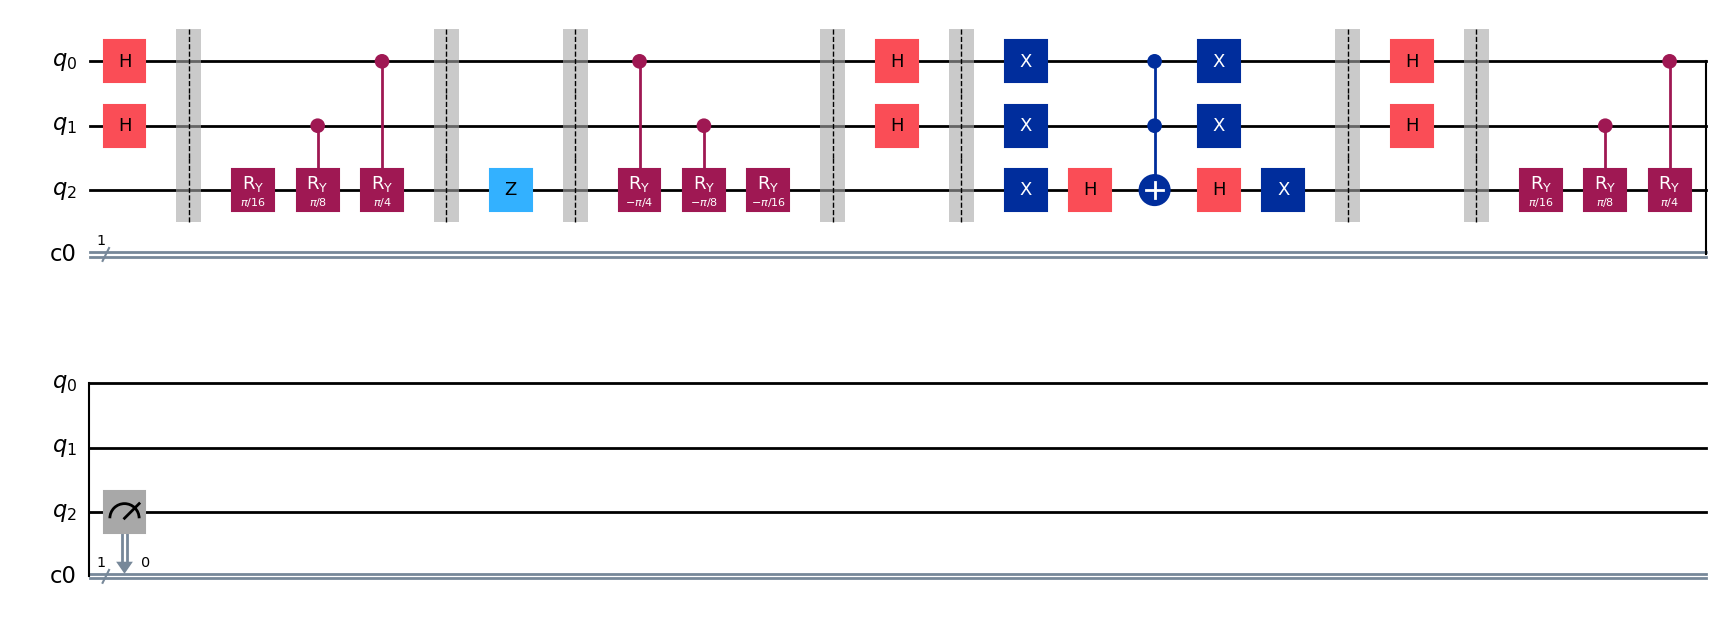

In [3]:
from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

qc = QuantumCircuit()
qc = create_grover_circuit(1, n_bits, b_max)
qc.draw("mpl", style="iqx")
#editor = CircuitComposer(circuit=qc)
#editor

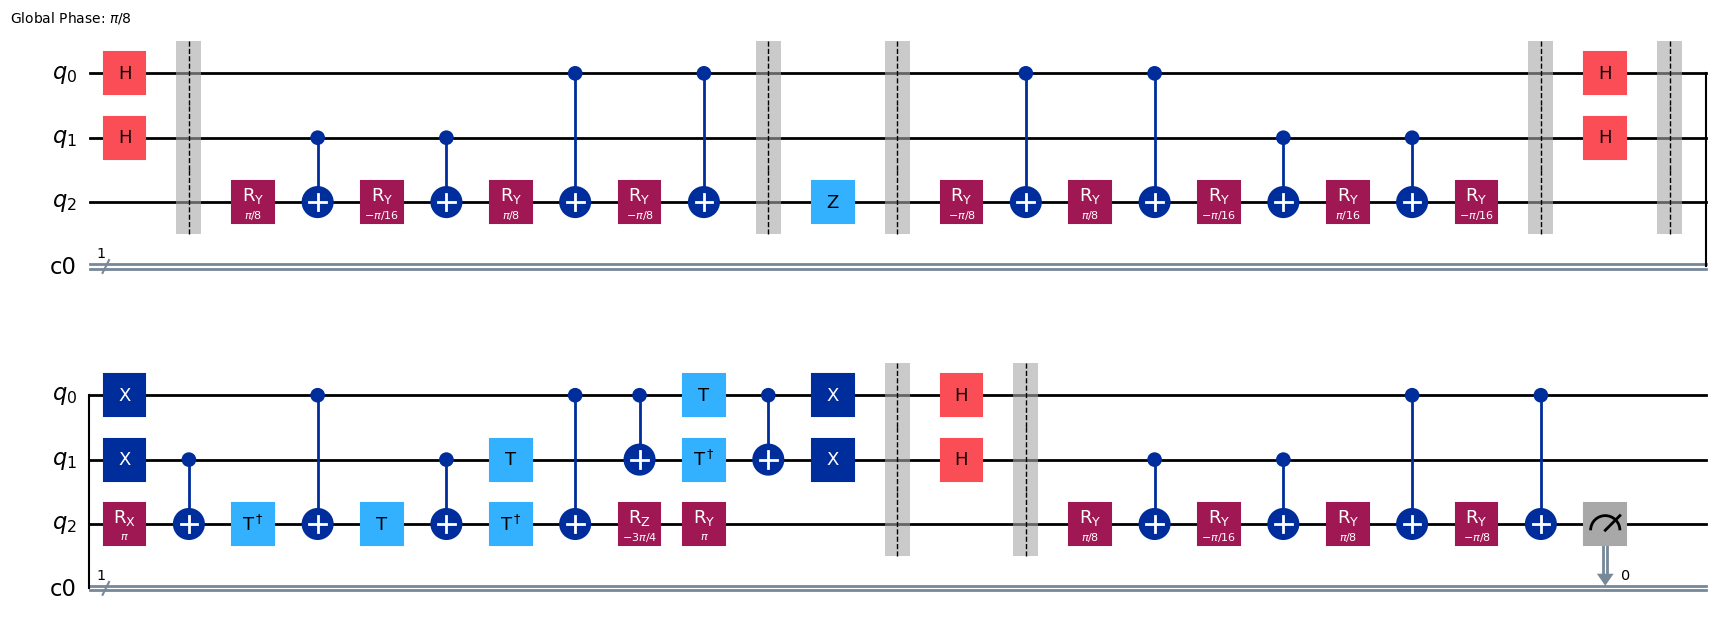

In [4]:
from qiskit import transpile
from qiskit.circuit.library import U1Gate, U2Gate, U3Gate

# Define a custom basis gate set
basis_gates = [U1Gate, U2Gate, U3Gate, "cx", "id", "x", "y", "z", "h", "s", "sdg", "t", "tdg", "rx", "ry", "rz"]

# Transpile the circuit using the basis gate set
transpiled_qc = transpile(qc, basis_gates=basis_gates)

# Draw the transpiled circuit
transpiled_qc.draw("mpl", style="iqx")


In [5]:
backend.run(transpiled_qc).result().get_counts()

{'0': 62, '1': 962}

In [6]:
!pip install qiskit.ignis


[notice] A new release of pip available: 23.1.1 -> 23.2
[notice] To update, run: pip install --upgrade pip


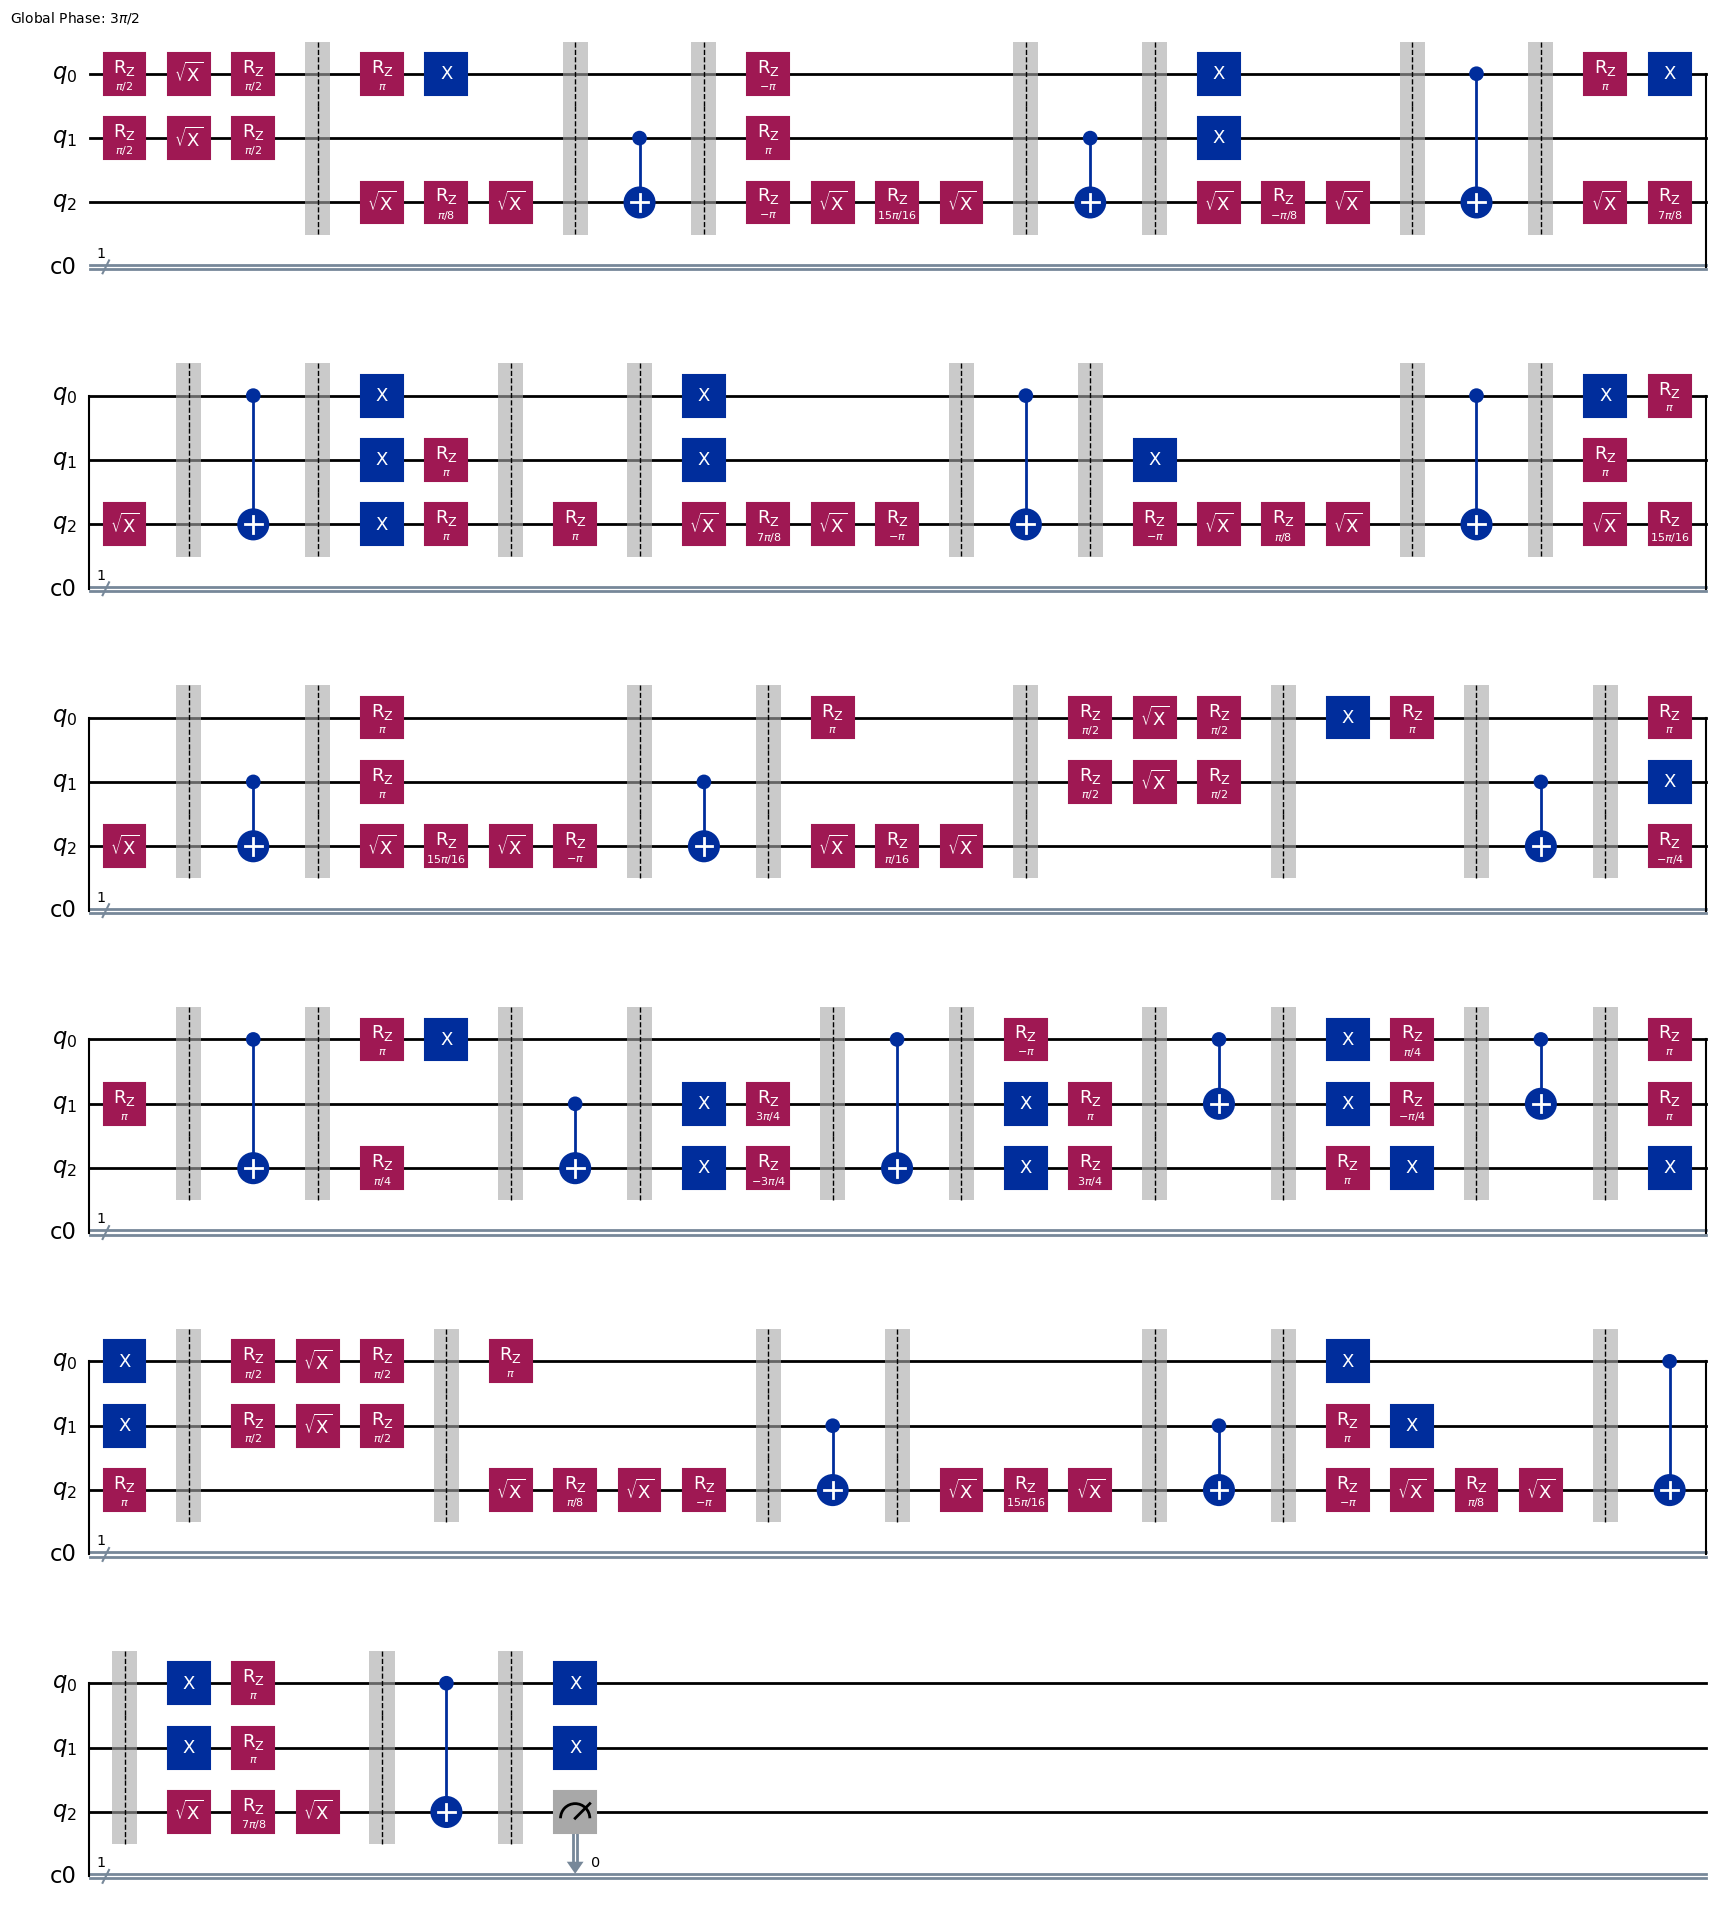

In [8]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit.ignis.verification.accreditation import AccreditationFitter, AccreditationCircuits

accsys = AccreditationCircuits(qc)

v = 10

circ_list, postp_list, v_zero = accsys.generate_circuits(v)
circ_list[(v_zero)%(v+1)].draw(style = 'iqx')


In [9]:
test_1 = AccreditationFitter()

job = execute(circ_list, backend, shots=1)
result = job.result()

counts = job.result().get_counts()

# Post-process the outputs and see if the protocol accepts
for run in range(10):
    test_1.single_protocol_run(result, postp_list, v_zero)
    print("Protocol run number",run+1,", outputs of the target",test_1.flag)

print("\nAP accepted",test_1.N_acc,"out of",test_1.num_runs,"times.")

theta = 0.05

test_1.bound_variation_distance(theta)
print("\nWith confidence",test_1.confidence,"AP certifies that VD is upper-bounded by",test_1.bound)

Protocol run number 1 , outputs of the target accepted
Protocol run number 2 , outputs of the target accepted
Protocol run number 3 , outputs of the target accepted
Protocol run number 4 , outputs of the target accepted
Protocol run number 5 , outputs of the target accepted
Protocol run number 6 , outputs of the target accepted
Protocol run number 7 , outputs of the target accepted
Protocol run number 8 , outputs of the target accepted
Protocol run number 9 , outputs of the target accepted
Protocol run number 10 , outputs of the target accepted

AP accepted 10 out of 10 times.

List of accepted outputs:
 {'0': 10}

With confidence 0.999909200140475 AP certifies that VD is upper-bounded by 0.16267942583732053


/tmp/ipykernel_5299/3330779399.py:10: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_1.single_protocol_run(result, postp_list, v_zero)
/tmp/ipykernel_5299/3330779399.py:18: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_1.bound_variation_distance(theta)


In [11]:
#Ahora generamos el modelo de ruido: 

noise_model = NoiseModel()

p1q = 0.003
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u1')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u3')
p2q = 0.03
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2q, 2), 'cx')

basis_gates = [U1Gate, U2Gate, U3Gate, "cx", "id", "x", "y", "z", "h", "s", "sdg", "t", "tdg", "rx", "ry", "rz"]

min_traps = 4
max_traps = 10


for num_trap_circs in range(min_traps,max_traps):

    test_4 = AccreditationFitter()
    for run in range(20):

        # Create target and trap circuits with different traps before just 10)
        circuit_list, postp_list, v_zero = accsys.generate_circuits(num_trap_circs)

        job = execute(circuit_list, backend, noise_model=noise_model, basis_gates=basis_gates, shots=1)
        result = job.result()

        # Post-process the outputs and see if the protocol accepts
        test_4.single_protocol_run(result, postp_list, v_zero)

    print("\nWith", num_trap_circs,
          "traps, AP accepted", test_4.N_acc,
          "out of", test_4.num_runs, "times.")
    test_4.bound_variation_distance(theta)
    print("With confidence", test_4.confidence,
          "AP with", num_trap_circs,
          "traps certifies that VD is upper-bounded by", test_4.bound)

/tmp/ipykernel_5299/2280103820.py:30: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_4.single_protocol_run(result, postp_list, v_zero)



With 4 traps, AP accepted 8 out of 20 times.
With confidence 1.0 AP with 4 traps certifies that VD is upper-bounded by 0.9714285714285711


/tmp/ipykernel_5299/2280103820.py:35: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_4.bound_variation_distance(theta)



With 5 traps, AP accepted 5 out of 20 times.
With confidence 1.0 AP with 5 traps certifies that VD is upper-bounded by 1

With 6 traps, AP accepted 8 out of 20 times.
With confidence 1.0 AP with 6 traps certifies that VD is upper-bounded by 0.693877551020408

With 7 traps, AP accepted 7 out of 20 times.
With confidence 1.0 AP with 7 traps certifies that VD is upper-bounded by 0.7083333333333335

With 8 traps, AP accepted 3 out of 20 times.
With confidence 1.0 AP with 8 traps certifies that VD is upper-bounded by 1

With 9 traps, AP accepted 3 out of 20 times.
With confidence 1.0 AP with 9 traps certifies that VD is upper-bounded by 1


In [ ]:
#Ahora generamos el modelo de ruido: 

noise_model = NoiseModel()

p1q = 0.0003
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u1')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u2')
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1q, 1), 'u3')
p2q = 0.003
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2q, 2), 'cx')

basis_gates = [U1Gate, U2Gate, U3Gate, "cx", "id", "x", "y", "z", "h", "s", "sdg", "t", "tdg", "rx", "ry", "rz"]

min_traps = 4
max_traps = 10


for num_trap_circs in range(min_traps,max_traps):

    test_4 = AccreditationFitter()
    for run in range(20):

        # Create target and trap circuits with different traps before just 10)
        circuit_list, postp_list, v_zero = accsys.generate_circuits(num_trap_circs)

        job = execute(circuit_list, backend, noise_model=noise_model, basis_gates=basis_gates, shots=1)
        result = job.result()

        # Post-process the outputs and see if the protocol accepts
        test_4.single_protocol_run(result, postp_list, v_zero)

    print("\nWith", num_trap_circs,
          "traps, AP accepted", test_4.N_acc,
          "out of", test_4.num_runs, "times.")
    test_4.bound_variation_distance(theta)
    print("With confidence", test_4.confidence,
          "AP with", num_trap_circs,
          "traps certifies that VD is upper-bounded by", test_4.bound)

/tmp/ipykernel_5299/1746781856.py:30: DeprecationWarning: single_protocol_run is being deprecated. Use AppendResult or AppendString
  test_4.single_protocol_run(result, postp_list, v_zero)



With 4 traps, AP accepted 18 out of 20 times.
With confidence 1.0 AP with 4 traps certifies that VD is upper-bounded by 0.3999999999999999


/tmp/ipykernel_5299/1746781856.py:35: DeprecationWarning: bound_variation_distance is being deprecated. Use FullAccreditation or MeanAccreditation
  test_4.bound_variation_distance(theta)



With 5 traps, AP accepted 19 out of 20 times.
With confidence 1.0 AP with 5 traps certifies that VD is upper-bounded by 0.3148148148148149

With 6 traps, AP accepted 16 out of 20 times.
With confidence 1.0 AP with 6 traps certifies that VD is upper-bounded by 0.32380952380952377

With 7 traps, AP accepted 19 out of 20 times.
With confidence 1.0 AP with 7 traps certifies that VD is upper-bounded by 0.23611111111111116

With 8 traps, AP accepted 15 out of 20 times.
With confidence 1.0 AP with 8 traps certifies that VD is upper-bounded by 0.26984126984126977
